In [1]:
from sklearn.metrics import recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
acct = pd.read_parquet('dsc180-fa23/q2_acctDF_final.pqt')
cons = pd.read_parquet('dsc180-fa23/q2_consDF_final.pqt')
inflows = pd.read_parquet('dsc180-fa23/q2_inflows_final.pqt')
outflows = pd.concat([
    pd.read_parquet('dsc180-fa23/q2_outflows_1sthalf_final.pqt'),
    pd.read_parquet('dsc180-fa23/q2_outflows_2ndhalf_final.pqt')
])
outflows['amount'] = -outflows['amount']
total = pd.concat([inflows, outflows])

In [3]:
outflows[outflows['prism_consumer_id'] == 0].sort_values(by='posted_date')

,prism_consumer_id,prism_account_id,memo_clean,amount,posted_date,category_description
420,0,acc_1,CASH APP*FREE XXXXXXXXXX CA 04/15,-150.00,2022-04-15,GENERAL_MERCHANDISE
281,0,acc_1,Payment to Chase card ending in XXXX 04/15,-100.00,2022-04-15,CREDIT_CARD_PAYMENT
735,0,acc_1,CASH APP*FREE XXXXXXXXXX CA 04/14,-60.00,2022-04-15,GENERAL_MERCHANDISE
591,0,acc_1,EMC SECURITY GA 04/16,-35.00,2022-04-18,GENERAL_MERCHANDISE
273,0,acc_1,TIAA-CREF LOAN LOAN REPAY PPD ID: XXXXXXXXXX,-41.39,2022-04-18,LOAN
...,...,...,...,...,...,...
255,0,acc_1,Online Transfer to SAV ...XXXX transaction#: X...,-300.00,2023-04-11,SELF_TRANSFER
902,0,acc_1,CASH APP*ADRIENNE XXXXXXXXXX CA 04/10,-200.00,2023-04-11,GENERAL_MERCHANDISE
557,0,acc_1,Amazon.com*HS08O2IE2 Amzn.com/bill WA 04/10,-46.00,2023-04-11,GENERAL_MERCHANDISE
200,0,acc_1,TRANSFER TO SAV XXXXXXXXX 04/12,-25.00,2023-04-12,SELF_TRANSFER


In [74]:
def diff_month(row):
    d1 = row[('datetime', 'max')]
    d2 = row[('datetime', 'min')]
    return (d1.year - d2.year) * 12 + d1.month - d2.month + 1

total['datetime'] = pd.to_datetime(total['posted_date'])
consumer_intervals = total[['prism_consumer_id', 'datetime']].groupby('prism_consumer_id').agg(['min', 'max'])
consumer_intervals['month_count'] = consumer_intervals[('datetime', 'max')] - consumer_intervals[('datetime', 'min')]
consumer_intervals['month_count'] = consumer_intervals.apply(diff_month, axis=1)
consumer_intervals = consumer_intervals.reset_index()

In [75]:
consumer_intervals = consumer_intervals[['prism_consumer_id', 'month_count']]

In [76]:
consumer_intervals.columns = ['prism_consumer_id', 'month_count']

In [79]:
by_category = total[['prism_consumer_id', 'category_description', 'amount']].groupby(['prism_consumer_id', 'category_description']).sum()
by_category = by_category.reset_index()
by_category = by_category.merge(consumer_intervals, on='prism_consumer_id', how='left')
by_category['per_month'] = by_category['amount'] / by_category['month_count']
by_category

,prism_consumer_id,category_description,amount,month_count,per_month
0,0,ACCOUNT_FEES,-7.26,13,-0.558462
1,0,ATM_CASH,-757.50,13,-58.269231
2,0,AUTOMOTIVE,-1528.71,13,-117.593077
3,0,CREDIT_CARD_PAYMENT,-5867.40,13,-451.338462
4,0,DEPOSIT,3438.07,13,264.466923
...,...,...,...,...,...
60502,5949,SELF_TRANSFER,-13304.71,17,-782.630000
60503,5949,SMALL_DOLLAR_ADVANCE,42.56,17,2.503529
60504,5949,TAX,2442.00,17,143.647059
60505,5949,TRAVEL,-257.99,17,-15.175882


In [94]:
pivot_df = by_category.pivot_table(index='prism_consumer_id', columns='category_description', values='per_month', aggfunc='sum')
pivot_df = pivot_df.fillna(0)
category_cols = list(pivot_df.columns)
pivot_df = pivot_df.merge(cons, on='prism_consumer_id', how='left')
pivot_df = pivot_df.merge(acct_on_cons, on='prism_consumer_id', how='left')
pivot_df

,prism_consumer_id,ACCOUNT_FEES,ATM_CASH,AUTOMOTIVE,BILLS_UTILITIES,BNPL,CHILD_DEPENDENTS,CREDIT_CARD_PAYMENT,DEPOSIT,EDUCATION,...,SELF_TRANSFER,SMALL_DOLLAR_ADVANCE,TAX,TRAVEL,UNCATEGORIZED,UNEMPLOYMENT_BENEFITS,evaluation_date,APPROVED,FPF_TARGET,balance
0,0,-0.558462,-58.269231,-117.593077,0.0,0.000000,0.0,-451.338462,264.466923,0.000000,...,-5.000000e+01,19.230769,217.653846,-29.757692,-223.342308,0.0,2023-04-13,1,0.0,16089.83
1,2,0.000000,-963.333333,-243.740000,0.0,0.000000,0.0,-506.286667,53.360000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,-680.193333,0.0,2022-02-15,1,0.0,25506.26
2,4,-2.538462,-189.700769,-172.497692,0.0,0.000000,0.0,-17885.556923,2509.252308,0.000000,...,-3.498057e-14,0.000000,0.000000,0.000000,-435.880000,0.0,2021-08-13,1,0.0,5521.39
3,7,-186.757692,-2741.128462,-128.490000,0.0,-37.600769,0.0,-3588.746154,1004.632308,0.000000,...,5.374969e+02,270.384615,-218.080769,-460.666154,-4754.599231,0.0,2021-08-08,1,0.0,8167.35
4,9,-0.692308,-204.902308,-520.136154,0.0,0.000000,0.0,-3322.920769,369.224615,0.000000,...,-2.538462e+01,0.000000,305.230769,-0.846923,-1140.353077,0.0,2023-04-19,1,0.0,13348.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973,5941,0.000000,-441.685455,-388.423636,0.0,0.000000,0.0,-283.465455,15.043636,0.000000,...,0.000000e+00,0.000000,22.350000,0.000000,-417.966364,0.0,2023-01-06,1,0.0,2058.81
2974,5943,-1.522500,-377.500000,-312.500000,0.0,0.000000,0.0,-1880.905000,4097.222500,0.000000,...,0.000000e+00,0.000000,0.000000,-3.667500,-393.675000,0.0,2023-02-03,1,0.0,2431.44
2975,5944,-0.210000,-1.995000,-29.875000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,-23.805000,0.0,2023-02-02,1,0.0,45.74
2976,5945,-6.930000,-1.080000,-98.866400,0.0,0.000000,0.0,0.000000,47.883200,-28.120000,...,9.200000e+00,0.000000,71.680000,-11.865200,-627.228400,0.0,2023-02-02,1,0.0,59.88


In [106]:
train, test = train_test_split(pivot_df, test_size=0.2, random_state=42)

In [151]:
feature_cols = category_cols
feature_cols = [
#     'ACCOUNT_FEES',
#     'ATM_CASH',
#     'AUTOMOTIVE',
#     'BILLS_UTILITIES',
    'BNPL',
    'CHILD_DEPENDENTS',
    'CREDIT_CARD_PAYMENT',
    'DEPOSIT',
    'EDUCATION',
    'ENTERTAINMENT',
    'ESSENTIAL_SERVICES',
    'EXTERNAL_TRANSFER',
    'FOOD_AND_BEVERAGES',
    'GENERAL_MERCHANDISE',
    'GIFTS_DONATIONS',
    'GROCERIES',
    'HEALTHCARE_MEDICAL',
    'HOME_IMPROVEMENT',
    'INSURANCE',
#     'INVESTMENT_INCOME',
#     'LOAN',
#     'MISCELLANEOUS',
#     'MORTGAGE',
#     'OTHER_BENEFITS',
    'OVERDRAFT',
#     'PAYCHECK',
#     'PAYCHECK_PLACEHOLDER',
    'PETS',
#     'REFUND',
#     'RENT',
#     'SELF_TRANSFER',
#     'SMALL_DOLLAR_ADVANCE',
#     'TAX',
#     'TRAVEL',
    'UNCATEGORIZED',
#     'UNEMPLOYMENT_BENEFITS'
]

In [152]:
mod = LogisticRegression(max_iter=300)
result = mod.fit(train[feature_cols + ['balance']], train['FPF_TARGET'])
result

/home/wxia/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300)

In [147]:
print(mod.coef_, mod.intercept_)

[[ 0.00924908 -0.00340258  0.0046077   0.00151063 -0.00046467  0.00767149
   0.00011729 -0.00046975]] [-0.29868554]


In [153]:
preds = mod.predict(test[feature_cols + ['balance']])

In [154]:
mod.score(test[feature_cols + ['balance']], test['FPF_TARGET'])

0.8204697986577181

In [155]:
roc_auc_score(test['FPF_TARGET'], preds)

0.5949104600271392

In [112]:
preds.mean()

0.09731543624161074

In [113]:
precision_score(test['FPF_TARGET'], preds)

0.4827586206896552

In [114]:
recall_score(test['FPF_TARGET'], preds)

0.2616822429906542

In [114]:
cons.sort_values(by='prism_consumer_id')

,prism_consumer_id,evaluation_date,APPROVED,FPF_TARGET
8,0,2023-04-13,1,0.0
43,2,2022-02-15,1,0.0
49,4,2021-08-13,1,0.0
69,7,2021-08-08,1,0.0
77,9,2023-04-19,1,0.0
...,...,...,...,...
2936,5941,2023-01-06,1,0.0
2954,5943,2023-02-03,1,0.0
2956,5944,2023-02-02,1,0.0
2957,5945,2023-02-02,1,0.0


In [14]:
acct.head()

,prism_consumer_id,prism_account_id,account_type,balance,balance_date
0,0,acc_0,SAVINGS,6182.60,2023-04-13
1,0,acc_1,CHECKING,9907.23,2023-04-13
2,2,acc_12,SAVINGS,17426.83,2022-02-15
3,2,acc_11,CHECKING,8079.43,2022-02-15
4,4,acc_16,SAVINGS,0.00,2021-08-13


In [69]:
cons[cons['FPF_TARGET']==1].head(15)

,prism_consumer_id,evaluation_date,APPROVED,FPF_TARGET
547,1601,2022-05-10,1,1.0
1004,3746,2022-11-11,1,1.0
1008,2630,2022-11-28,1,1.0
1011,2931,2023-04-07,1,1.0
1012,3414,2023-04-22,1,1.0
1015,2659,2022-12-01,1,1.0
1017,2444,2023-01-08,1,1.0
1018,2561,2023-02-19,1,1.0
1020,2863,2022-11-11,1,1.0
1021,3166,2022-12-12,1,1.0


In [34]:
all_combinations = pd.DataFrame([(i, j, k) for i in acct['prism_consumer_id'].unique() for j in range(12) for k in range(2019, 2024)], columns=['consumer_id', 'month', 'year'])

In [35]:
all_combinations

,consumer_id,month,year
0,0,0,2019
1,0,0,2020
2,0,0,2021
3,0,0,2022
4,0,0,2023
...,...,...,...
178675,5949,11,2019
178676,5949,11,2020
178677,5949,11,2021
178678,5949,11,2022


0.0
0.0


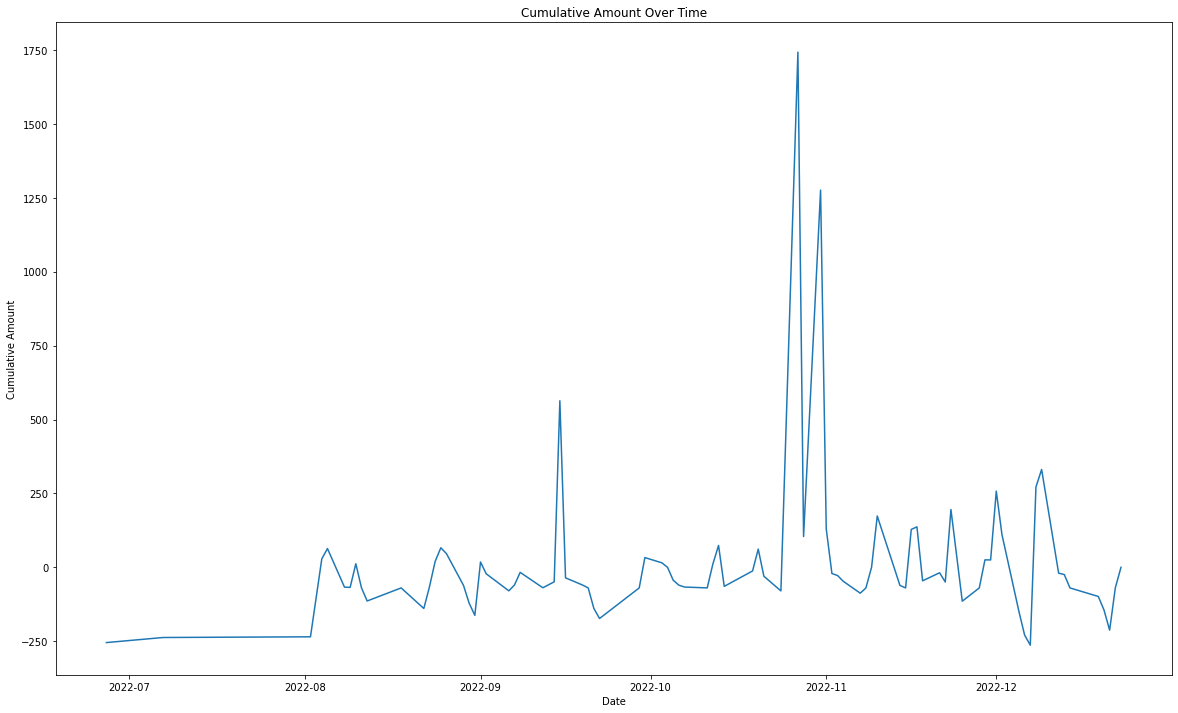

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

d1 = pd.read_parquet('dsc180-fa23/q2_inflows_final.pqt')
d2 = pd.read_parquet('dsc180-fa23/q2_outflows_1sthalf_final.pqt')
d3 = pd.read_parquet('dsc180-fa23/q2_outflows_2ndhalf_final.pqt')

d2['amount'] = -d2['amount']
d3['amount'] = -d3['amount']

merged_table = pd.concat([d1,d2,d3],axis=0, join='outer')

def curve(consumer_id, df):
    data = df[df['prism_consumer_id'] == consumer_id]
    data = data.sort_values('posted_date')
    d = data.groupby(['prism_consumer_id', 'posted_date'], as_index=False).sum(numeric_only=True)
    
    current_balance = acct[acct['prism_consumer_id'] == consumer_id]['balance'].sum()
    print(current_balance)
    d['balance'] = d['amount'].cumsum()
    
    current_balance = acct[acct['prism_consumer_id'] == consumer_id]['balance'].sum()
    d['balance'] = d['balance'] + current_balance - d['balance'].iloc[-1]
    print(d['balance'].iloc[-1])
    plt.figure(figsize=(20, 12))
    plt.plot(d['posted_date'].to_numpy(), d['balance'].to_numpy())
    plt.xlabel('Date')
    plt.ylabel('Cumulative Amount')
    plt.title('Cumulative Amount Over Time')
    plt.show()

curve(2760, merged_table)

In [47]:
acct_on_cons = acct[['prism_consumer_id', 'balance']].groupby('prism_consumer_id').sum()


In [48]:
cons_with_balance = cons.join(acct_on_cons, on='prism_consumer_id')
cons_with_balance.sort_values(by='balance').head(500)

,prism_consumer_id,evaluation_date,APPROVED,FPF_TARGET,balance
122,13,2022-02-14,1,0.0,-7699.94
2380,5750,2022-10-23,1,0.0,-2204.73
2670,4214,2023-01-17,1,1.0,-1852.21
2162,5352,2022-10-04,1,0.0,-1466.21
2455,5772,2022-12-08,1,0.0,-1351.09
...,...,...,...,...,...
1450,2892,2023-02-01,1,0.0,8.08
2303,4418,2022-11-04,1,0.0,8.12
2451,4480,2022-12-28,1,0.0,8.14
1795,2017,2022-11-06,1,1.0,8.20


In [24]:
mod = LogisticRegression()
mod.fit(cons_with_balance[['balance']], cons_with_balance['FPF_TARGET'])

LogisticRegression()

In [77]:
mod.predict(cons_with_balance[['balance']])

array([0., 0., 0., ..., 0., 0., 0.])

In [107]:
def predict(arr):
    res = [1 if x < 100 else 0 for x in arr]
    return res

In [108]:
(predict(cons_with_balance['balance']) == cons_with_balance['FPF_TARGET']).mean()

0.7384150436534587

In [109]:
precision_score(cons_with_balance['FPF_TARGET'], predict(cons_with_balance['balance']))

0.37915742793791574

In [110]:
recall_score(cons_with_balance['FPF_TARGET'], predict(cons_with_balance['balance']))

0.6096256684491979

In [111]:
roc_curve(cons_with_balance['FPF_TARGET'], predict(cons_with_balance['balance']))

(array([0.        , 0.23169218, 1.        ]),
 array([0.        , 0.60962567, 1.        ]),
 array([inf,  1.,  0.]))